In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
from torch import nn
import os, pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

meta = unpickle("cifar100/meta")
# train = unpickle("cifar100/train")
# test = unpickle("cifar100/test")

### Load Labels Names From original CIFAR 100 Dataset

In [2]:
# meta.keys() : dict_keys([b'fine_label_names', b'coarse_label_names'])
# meta[b'fine_label_names'] : [b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver'......]
label_names = [name.decode() for name in meta[b'fine_label_names']]
label_names[:5], len(label_names)

(['apple', 'aquarium_fish', 'baby', 'bear', 'beaver'], 100)

In [3]:
def myPicturePlotting(row, col, pictures:list[np.array], name_list=None):
    """
    can plot many pictures of images, and display names optionally
    """
    # length parsing
    length = len(pictures)
    
    # dimension checking
    if row*col < length:
        row = int(np.sqrt(length)) + 1
        col = row    
        
    fig, axs = plt.subplots(row, col, figsize=(10,10))

    idx = 0
    if row == 1:
        axs = [axs]
    if col == 1:
        axs = [axs]
    
    
    for r in range(row):
        for c in range(col):
            axs[r][c].imshow(pictures[idx])
            if name_list != None:
                axs[r][c].set_title(name_list[idx])
                
            axs[r][c].set_xticks([])
            axs[r][c].set_yticks([])
            idx += 1
            if length == idx:
                break
        if length == idx:
            break
    plt.show()
    
def normalize(img):
    # tensor or array
    return ((img / 255) - 0.5) / 0.5

def denormalize(img:np.ndarray):
    newimg = ((img * 0.5) + 0.5) * 255
    # if isinstance(img, np.ndarray):
    #     img = np.clip(img,a_min= 0,a_max=255)
    # elif isinstance(img, torch.Tensor):
    #     img = torch.clip(img,min=0, max=255)
    # else:
    #     img = np.clip(img,a_min= 0,a_max=255)
    return newimg #.astype(np.uint8)

def imgChangeAxis(img:np.ndarray):
    """
    from (N, width, height, 3) to (N, 3, width, height)
    or (width, height, 3) to (3, width, height)
    """
    if len(img.shape) == 4:
        R = img[:,:,:,0]
        G = img[:,:,:,1]
        B = img[:,:,:,2]
        return np.stack((R,G,B),axis=1)
        
    elif len(img.shape) == 3:
        R = img[:,:,0]
        G = img[:,:,1]
        B = img[:,:,2]
        return np.stack((R,G,B))
    else:
        raise Exception("Dimension Not matching")
    
def imgDeChangeAxis(img:np.ndarray):
    """
    from (N, 3, width, height) to (N, width, height, 3)
    or (3, width, height) to (width, height, 3)
    """
    if len(img.shape) == 4:
        return np.stack((img[:,0],img[:,1],img[:,2]), axis=-1)
    elif len(img.shape) == 3:
        return np.stack((img[0],img[1],img[2]), axis=-1)
 

### Load Image Data (with labels) and turn into np array

In [4]:
img_list = []
label_list = []
name_list = []

for name in os.listdir("./eval"):
    path = f"eval/{name}"
    label = int(name.split("_")[0])
    img = imgChangeAxis(np.array(Image.open(path))) 
    img_list.append(img)
    label_list.append(label)
    name_list.append(name)
    
print(img_list[0].shape) #,myPicturePlotting(1,1,[imgDeChangeAxis(img_list[0])])

(3, 32, 32)


# Model Part

#### Simple Transformer & prepare the images and labels (turn into tensor and put into GPU)

In [5]:
from torchvision.models import list_models, get_weight, get_model, get_model_weights
import torch

device = "cuda"
# I use my normalize function :)

img_tensor = normalize(torch.tensor(np.stack(img_list))).to(torch.float32).to(device)

label_tensor = torch.tensor(np.stack(label_list)).to(torch.int64).to(device)


# userful for clear cache
def myStrongCacheClear(func):
    def wrapper(*args, **kwargs):
        with torch.no_grad():
            func(*args, **kwargs)
            torch.cuda.empty_cache()
    return wrapper

def myATKCacheClear(func):
    def wrapper(*args, **kwargs):
        func(*args, **kwargs)
        torch.cuda.empty_cache()
    return wrapper

c:\MiniConda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from pytorchcv.model_provider import get_model as ptcv_get_model
import torch
from torch.autograd import Variable
from copy import deepcopy

resnet110 = ptcv_get_model("resnet110_cifar100", pretrained=True).cuda().eval()
preresnet164bn = ptcv_get_model("preresnet164bn_cifar100", pretrained=True).cuda().eval()
seresnet110 = ptcv_get_model("seresnet110_cifar100", pretrained=True).cuda().eval()
densenet40_k36_bc = ptcv_get_model("densenet40_k36_bc_cifar100", pretrained=True).cuda().eval()
diaresnet164bn = ptcv_get_model("diaresnet164bn_cifar100", pretrained=True).cuda().eval()

# TODO I don't know how to handle the eval and cuda mode of an ensemble model
# so I directly put them all in cuda

class EnsembleModel(torch.nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = models

    def forward(self, x):
        # average ensemble technique
        N = len(self.models)
        outputs = 0
        for model in self.models:
            outputs += model(x)
        
        avg_output = outputs / N
        return avg_output

ensemble_model = EnsembleModel([resnet110, preresnet164bn, seresnet110, densenet40_k36_bc, diaresnet164bn])

In [50]:
output = ensemble_model(img_tensor[0:1])

### Some preparation for attack

In [7]:
from torchattacks import FGSM, PGD

from torchattacks.attack import Attack


def myTargetedAttack(atk:Attack, img_tensor, target_label_tensor, batch_size = 64):
    # torchattack init
    atk.set_normalization_used(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    atk.set_mode_targeted_by_label(quiet=True)
    atk.set_device("cuda")
    
    N, _, _, _ = img_tensor.shape
    adv_img = []
    # start attack
    for i in range(0, N, batch_size):
        adv_img.append(atk(img_tensor[i:i+batch_size], target_label_tensor[i:i+batch_size]))
    torch.cuda.empty_cache()
    return torch.cat(adv_img)

@torch.no_grad()
def pred(model, img):
    # model.eval()
    # model.cuda()
    # print(model.training)
    idx = 0
    res = []
    while idx < img.shape[0]:
        res.append(torch.argmax(model(img[idx:idx+64]), dim=1))
        idx += 64
    # model.train()
    torch.cuda.empty_cache()
    return torch.cat(res)

def calculateSuccessRate(model: nn.Module, adv_img_tensor, target_label_tensor):
    N, _, _, _ = adv_img_tensor.shape
    return torch.eq(pred(model, adv_img_tensor), target_label_tensor).sum().item() / N

FGSM_atk = FGSM(ensemble_model, eps = 4 / 255)
PGD_atk_10 = PGD(ensemble_model, eps = 4 / 255, steps = 10)
PGD_atk_20 = PGD(ensemble_model, eps = 4 / 255, steps = 20)
PGD_atk_40 = PGD(ensemble_model, eps = 4 / 255, steps = 40)
PGD_atk_80 = PGD(ensemble_model, eps = 4 / 255, steps = 80)
PGD_atk_160 = PGD(ensemble_model, eps = 4 / 255, steps = 160)
PGD_atk_320 = PGD(ensemble_model, eps = 4 / 255, steps = 320)



maps = {
    "FGSM_atk" : FGSM_atk,
    "PGD_atk_10" : PGD_atk_10,
    "PGD_atk_20" : PGD_atk_20,
    "PGD_atk_40" : PGD_atk_40,
    "PGD_atk_80" : PGD_atk_80,
    "PGD_atk_160" : PGD_atk_160,
    "PGD_atk_320" : PGD_atk_320
}

target_label_tensor = torch.zeros(500, dtype=torch.int64).to('cuda')

Failed to set device automatically, please try set_device() manual.
Failed to set device automatically, please try set_device() manual.
Failed to set device automatically, please try set_device() manual.
Failed to set device automatically, please try set_device() manual.
Failed to set device automatically, please try set_device() manual.
Failed to set device automatically, please try set_device() manual.
Failed to set device automatically, please try set_device() manual.


### Start Attack! Generate Adversarial Examples

In [18]:
success_rate_map = {}
adv_img_maps = {}
for model_name, model in maps.items():
    adv_img = myTargetedAttack(model, img_tensor, target_label_tensor, batch_size = 64)
    adv_img_maps[model_name] = adv_img
    
    success_rate_map[model_name] = calculateSuccessRate(ensemble_model, adv_img, target_label_tensor)

##### Some test

In [8]:
res_adv = myTargetedAttack(PGD_atk_320, img_tensor, target_label_tensor, batch_size = 64)
sr = calculateSuccessRate(ensemble_model, res_adv, target_label_tensor)
sr

0.88

In [20]:
sr = calculateSuccessRate(ensemble_model, res_adv, label_tensor)
sr

0.118

In [67]:
PGD_atk_1000 = PGD(ensemble_model, eps = 4 / 255, steps = 1000)
test_adv = myTargetedAttack(PGD_atk_1000, img_tensor, target_label_tensor, batch_size = 80)
sr = calculateSuccessRate(ensemble_model, test_adv, target_label_tensor)
sr

Failed to set device automatically, please try set_device() manual.


0.89

##### Attack Result

In [19]:
success_rate_map

{'FGSM_atk': 0.02,
 'PGD_atk_10': 0.662,
 'PGD_atk_20': 0.766,
 'PGD_atk_40': 0.814,
 'PGD_atk_80': 0.856,
 'PGD_atk_160': 0.866,
 'PGD_atk_320': 0.888}

### Plotting out the result

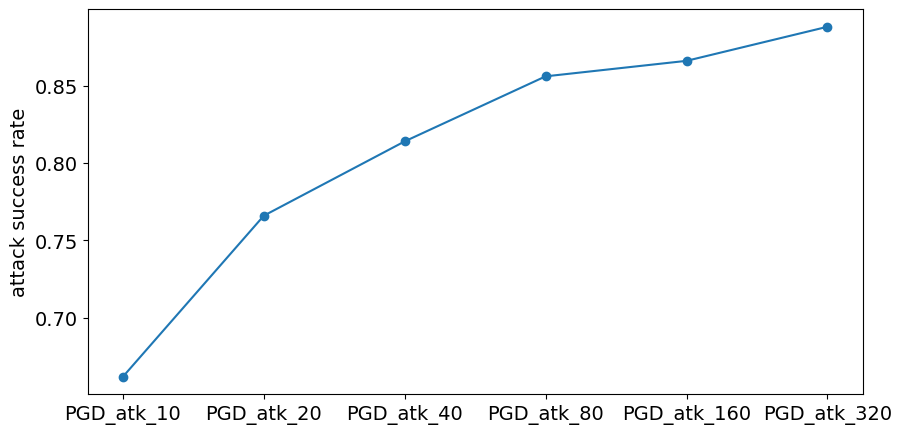

In [39]:
plt.figure(figsize=(10,5))
plt.ylabel("attack success rate", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.scatter(list(success_rate_map.keys())[1:], list(success_rate_map.values())[1:])
plt.plot(list(success_rate_map.keys())[1:], list(success_rate_map.values())[1:])

### Save Adversarial images

##### Check Budget first

In [47]:
diff = ((imgDeChangeAxis(res_adv.cpu().numpy()) * 0.5 + 0.5) * 255).astype(np.int16) - imgDeChangeAxis(np.stack(img_list))
greater = diff[diff >= 0]
lesser = diff[diff < 0]
lesser.min(), greater.max()

(-5, 4)

In [50]:
diff = diff + 4
diff[diff > 0] = 0
diff = -diff

output_adv = ((imgDeChangeAxis(res_adv.cpu().numpy()) * 0.5 + 0.5) * 255).astype(np.int16) + diff.reshape(500,32,32,3)

In [55]:
output_adv.max(), output_adv.min(), output_adv.shape

(255, 0, (500, 32, 32, 3))

### Saving

In [56]:
from PIL import Image
for idx, adv_img in enumerate(output_adv.astype(np.uint8)):
    # ensure budget is between 4 epsilon
    output_images = Image.fromarray(adv_img)
    output_images.save("adv_imgs/" + name_list[idx])

### Checking

In [57]:
img_check_list = []
label_check_list = []

for name in os.listdir("./adv_imgs"):
    path = f"adv_imgs/{name}"
    label = int(name.split("_")[0])
    img = imgChangeAxis(np.array(Image.open(path))) 
    img_check_list.append(img)
    label_check_list.append(label)
    
print(img_check_list[0].shape)

(3, 32, 32)


In [58]:
img_check_tensor = normalize(torch.tensor(np.stack(img_check_list))).to(torch.float32).to(device)

label_check_tensor = torch.tensor(np.stack(label_check_list)).to(torch.int64).to(device)

In [59]:
sr = calculateSuccessRate(ensemble_model, img_check_tensor, label_check_tensor)
sr # Success !

0.134

### Check budget

In [66]:
np.max(np.abs(np.stack(img_check_list).astype(np.int16) - np.stack(img_list).astype(np.int16)))

4

#### 對於帶有 BN 這些層的網路，如果預測時沒有轉 eval 模式，好像會改掉網路內的結構，導致要重新訓練

##### diaresnet164bn and preresnet164bn takes very long time :(

##### the effect of 40 steps and 120 steps are almost same

###### 120: 348

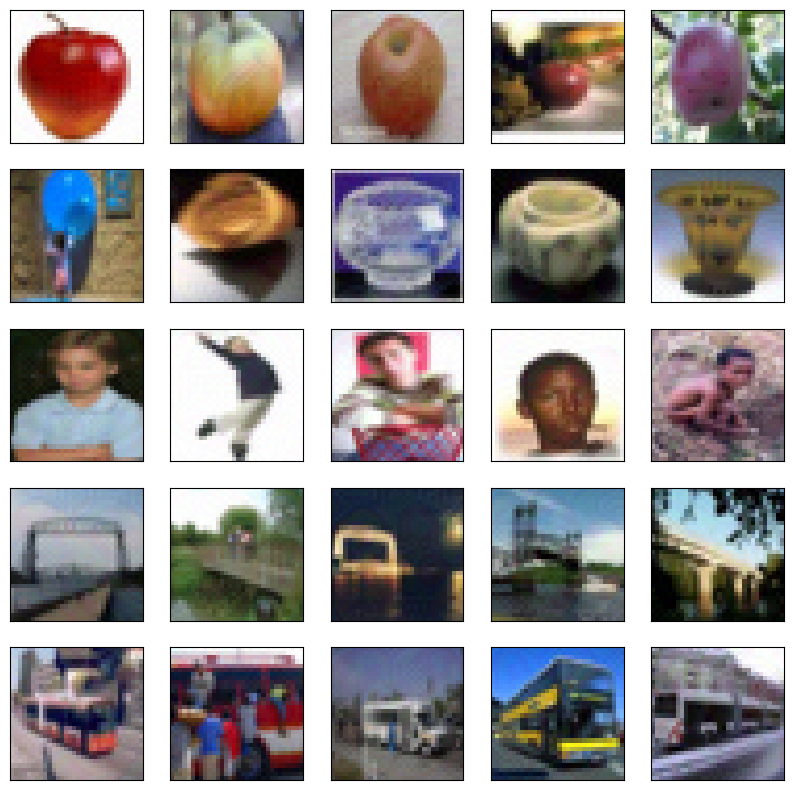

In [10]:
myPicturePlotting(5,5,(imgDeChangeAxis(res_adv.cpu().numpy()[:25]) * 0.5 + 0.5))